## 循环神经网络的从零开始实现

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
print(train_iter)
count = 3
for i in train_iter:
    print(i)
    if (count == 0): break
    count-= 1

(tensor([[21, 19,  1,  ..., 16,  7, 10],
        [ 2,  8,  1,  ...,  1, 18, 12],
        [ 2, 16,  5,  ..., 10,  2, 11],
        ...,
        [ 3,  2, 12,  ...,  8,  2,  2],
        [ 7, 13,  2,  ...,  4,  6, 15],
        [12,  2,  1,  ...,  2,  1, 11]]), tensor([[19,  1,  9,  ...,  7, 10,  1],
        [ 8,  1,  3,  ..., 18, 12,  4],
        [16,  5,  6,  ...,  2, 11,  1],
        ...,
        [ 2, 12, 12,  ...,  2,  2,  6],
        [13,  2,  1,  ...,  6, 15,  2],
        [ 2,  1,  9,  ...,  1, 11, 10]]))
(tensor([[ 1,  8,  7,  ...,  4, 23,  1],
        [ 4,  8,  8,  ...,  3,  8,  1],
        [ 1,  9,  5,  ...,  4, 10,  4],
        ...,
        [ 6,  1,  4,  ...,  6,  5,  8],
        [ 2,  1,  4,  ...,  1,  3,  9],
        [10,  2, 17,  ...,  7,  6, 12]]), tensor([[ 8,  7,  1,  ..., 23,  1,  7],
        [ 8,  8,  2,  ...,  8,  1,  2],
        [ 9,  5,  8,  ..., 10,  4, 11],
        ...,
        [ 1,  4,  3,  ...,  5,  8,  9],
        [ 1,  4,  6,  ...,  3,  9,  5],
        [ 2, 17,  1,

In [2]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [3]:
## Understanding F.one_hot
X = torch.arange(10).reshape((2, 5))
X_ = F.one_hot(X.T, 28) ## transpose
print(X_.shape)
print(X_[1][0])
print(X)

torch.Size([5, 2, 28])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])


In [4]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [5]:
def rnn(inputs, state, params):
    '''
        param: state, initialization states
        param: W's , h's, b's
    '''
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        # torch.mm matrix multiplication
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [6]:
class RNNModelScratch:  
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        # forward_fn RNN LSTM GRU
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [7]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [8]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """
        在`prefix`后面生成新字符。
        params : prefix 
        params : num_preds number of predictions required after prefix
    """
    print('prefix : ', prefix, len(prefix))
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    # get the last outputs as a tensor
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
#     print(len(outputs))
    print(outputs)
    
    # Make required number of predictions
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())


prefix :  time traveller  15
[3, 5, 13, 2, 1, 3, 10, 4, 22, 2, 12, 12, 2, 10, 1]


'time traveller ljljljljlj'

In [9]:
def grad_clipping(net, theta):  
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [10]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        
        
        y_hat, state = net(X, state)
        # loss function
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [11]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 70474.3 标记/秒 cuda:0
prefix :  time traveller 14
[3, 5, 13, 2, 1, 3, 10, 4, 22, 2, 12, 12, 2, 10]
time traveller with a slight accession ofcheerfulness really thi
prefix :  traveller 9
[3, 10, 4, 22, 2, 12, 12, 2, 10]
travelleryou can show black is white by argument said filby


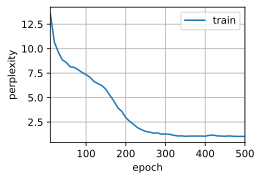

In [12]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.3, 72297.9 标记/秒 cuda:0
prefix :  time traveller 14
[3, 5, 13, 2, 1, 3, 10, 4, 22, 2, 12, 12, 2, 10]
time travellerit s against reason said filbywhat be moce absent 
prefix :  traveller 9
[3, 10, 4, 22, 2, 12, 12, 2, 10]
traveller after the pauserequired for the proper assimilati


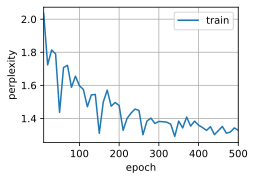

In [13]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

## 循环神经网络的简洁实现

In [14]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
# What does num_steps means 
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [15]:
num_hiddens = 256
# len(vocab) - the embedding size: since we are using one-hot embedding, the embedding size is length of the vocabulary
# num_hiddens - the dimension of the W's h's and b's
rnn_layer = nn.RNN(len(vocab), num_hiddens)
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [16]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
print('X size')
print(X.shape)
# Y : Y from the previous lecture
# state : original state from the previous lecture
# new state : output state from the previous lecture
Y, state_new = rnn_layer(X, state)

Y.shape, state_new.shape

X size
torch.Size([35, 32, 28])


(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [17]:
class RNNModel(nn.Module):
    """循环神经网络模型。"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        # inputs 1 x 1
        # X 1 x 1 x 28
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        # Y 1 x 1 x 256
        Y, state = self.rnn(X, state)
        # output 1 x 28 
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

In [18]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellern uu aquua'

perplexity 1.3, 258476.7 tokens/sec on cuda:0
time travellerit s against reason said filbyware curesusaid the 
travellerabktactingryars at oreatide ne ar it whe enbugrave


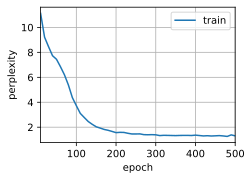

In [19]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

In [20]:
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerit s again'